# DSCI 100 Group 12 Project Report

# Imports

In [1]:
### Run this cell before continuing.
import random

import altair as alt
import pandas as pd
import sklearn
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics.pairwise import euclidean_distances

alt.data_transformers.disable_max_rows()
np.random.seed(1)

# Introduction

## Background

The sinking of the Titanic is one of the most known shipwrecks in history. The widely regarded "unsinkable" Titanic sank after striking an iceberg on April 15, 1912, while on her first voyage. Out of 2224 passengers and crew, 1502 perished because there were not enough lifeboats to go around.

Some people appeared to have higher survival rates than others, despite the fact that survival sometimes involved a certain amount of luck. Based on the provided passenger information, we’d love to explore the dataset and answer the question: what sorts of people were more likely to survive?

## Question

Given a passenger on the Titanic, predict whether they will survive the shipwreck.

## Dataset
The dataset we'll be using is from https://www.kaggle.com/competitions/titanic/data. It already splits our data into a training set to train our model with and a test set to evaluate our model on unseen data. 

The dataset contains a number of features such as the passengers sex, age, cabin number, and more. Our target variable will be the `Survival` feature which is 0 if the passenger did not survive, and 1 if they survived

More info about the dataset and it's features are described below

# Preliminary Exploratory Data Analysis

## Reading the data
> Note: there doesn't seem to be a URL for the dataset. Therefore, we've downloaded the data from Kaggle using the link https://www.kaggle.com/competitions/titanic/data and have moved the csv files into a data directory.

In [2]:
training_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
training_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Description of Features
These were taken from https://www.kaggle.com/competitions/titanic/data

| Variable | Definition                                                                                          |
|----------|-----------------------------------------------------------------------------------------------------|
| survival | 1 = survived, 0 = did not survive                                                                   |
| pclass   | Ticket class - a proxy for socio-econimic status 1 = 1st (Upper), 2 = 2nd (Middle), 3 = 3rd (Lower) |
| sex      | Sex (male or female)                                                                                |
| age      | Age in years - is fractional if less than 1 - if it's estimated, it's in the form xx.5              |
| sibsp    | # of siblings / spouses aboard the Titanic                                                          |
| parch    | # of parents / children aboard the Titanic                                                          |
| ticket   | Ticket number                                                                                       |
| fare     | Passenger fare                                                                                      |
| cabin    | Cabin number                                                                                        |
| embarked | Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton                                  |

## Cleaning and wrangling data into a tidy format

The data is already clean and wrangled. Namely
- Each row is a single observation (a single passenger)
- Each column is a single variable
- Each cell contains a single value

Furthermore, the column names are easy to read and use already (no spaces in them) and missing values are represented with `NaN`.

## Summarizing the Data

Here we use `DataFrame::info()` and `DataFrame::describe()` to discover

1. The number of observations for each column and whether we're missing any observations
2. What `Dtype` each column/feature has
3. The mean, std, quartiles, min and max of numerical features

In [3]:
display(training_data.info())
display(training_data.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


We can see that the features with missing values include `Age`, `Cabin` and `Embarked`. `Cabin` has the most missing number of values, so it may not be useful for our model to learn this feature.

Furthermore, `Name` in our training set is a unique feature for each passenger, so it may not be that useful. We'll expand further on this in the [Methods](#methods) section.

Next, we find the number of observations in each class

In [4]:
display(training_data['Survived'].value_counts())
display(training_data['Survived'].value_counts(normalize=True))

0    549
1    342
Name: Survived, dtype: int64

0    0.616162
1    0.383838
Name: Survived, dtype: float64

We can see there are 549 passengers in the training set that did not survive (roughly 61%) and 342 passengers that survived (roughly 38%).

## Visualizing the Data


For visualizing the data, we'll focus on the following subset of features for now. We explain in the [Features/Variables/Columns](#featuresvariablescolumns) section which predictor variables we'll use and why.

In [5]:
training_data_selected = training_data[training_data["Age"].notnull()].loc[:,["Survived","Sex","Pclass","Age","SibSp","Parch","Fare"]]
training_data_selected

,Survived,Sex,Pclass,Age,SibSp,Parch,Fare
0,0,male,3,22.0,1,0,7.2500
1,1,female,1,38.0,1,0,71.2833
2,1,female,3,26.0,0,0,7.9250
3,1,female,1,35.0,1,0,53.1000
4,0,male,3,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
885,0,female,3,39.0,0,5,29.1250
886,0,male,2,27.0,0,0,13.0000
887,1,female,1,19.0,0,0,30.0000
889,1,male,1,26.0,0,0,30.0000


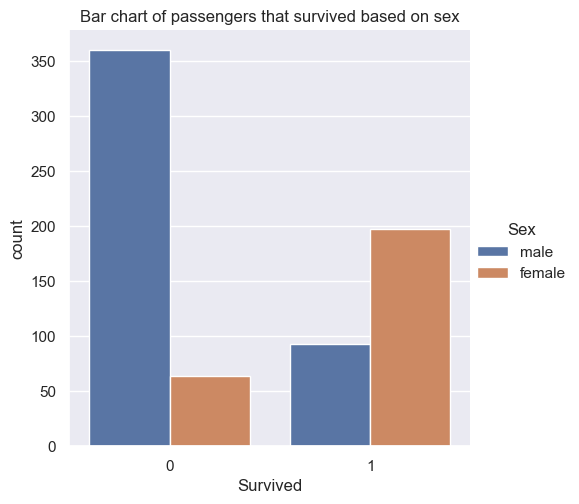

In [6]:
import seaborn as sns
sns.set()
sns.catplot(x = 'Survived', data = training_data_selected, kind = 'count', hue = 'Sex').set(title='Bar chart of passengers that survived based on sex')

From this we can see that more females survived than males since there were more than 200 that survived compared to only about 100 males survived).
Furthermore, more than 400 males did not survive compared to just under 100 females survived.

After some further research, it seems that the rule for loading the lifeboats were women and children first. If this was the case, we'd expect the percentage of those with younger ages to have survived more than the percentage of adults/older people if children were prioritized. Let's see if this is the case

In [7]:
(
    alt.Chart(training_data_selected)
    .mark_bar()
    .encode(
        x= alt.X("Age", bin=alt.Bin(maxbins=30)),
        y=alt.Y("count()", stack=False),
        color = 'Survived:N'
    )
    .properties(
        width=600,
        height=400
    )
    .facet(
        facet=alt.Facet('Sex', header=alt.Header(labelFontSize=14)),
        title='Histogram of Passenger Age Colored by Survival and Split by Sex'
    )
    .configure_axis(titleFontSize=14)
)


c:\anaconda3\envs\cpsc330\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.FacetChart(...)

Here we show the distribution of the `Age` variable, using color to separate those who survived and those who didn't. We facet the plot to separate further by sex.

We can see that those with ages less than or equal to 10, regardless of sex, had a much higher survival rate. Furthermore, females seemed to have better chances of surviving than males. This does in fact provide better evidence that there was a rule for loading females and children first in lifeboats.

Next, let's see if the ticket class (a proxy for social economic status) plays a role in the survival rate.

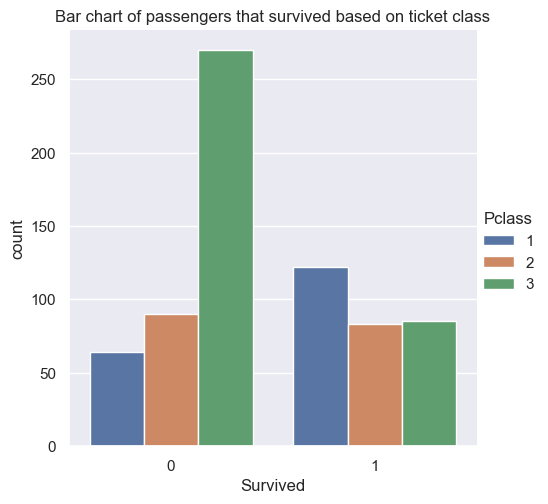

In [8]:
sns.catplot(x = 'Survived', data = training_data_selected, kind = 'count', hue = 'Pclass').set(title='Bar chart of passengers that survived based on ticket class')

From this we can see that most people who failed to survive are from the 3rd class, whereas those that survived the most are from the 1st class.

Next, let's compare the survival rate with the price of the cabin. We create a histogram with the x-axis as the passenger fairs grouped into buckets and the y-axis showing the percentage of passengers in the buckets that survived.

In [9]:
(
    alt.Chart(training_data_selected, title="Normalized Histogram of Fare Price to Percentage of Survivors")
    .mark_bar()
    .encode(
        x= alt.X("Fare", bin=alt.Bin(maxbins=15), title="Fare (£)"),
        y=alt.Y("count()", stack="normalize", axis=alt.Axis(format='%'), title="Percentage of Records"),
        color = 'Survived:N'
    )
)


c:\anaconda3\envs\cpsc330\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

Interestingly, we can observe that those who paid very cheap fares did not survive as much compared to those who paid more expensive fares greater than or equal to £50. We can see an outlier with a 100% survival rate for those that paid a fare of more than £500.

# Methods and Results

## Procedure for Data Analysis

To conduct our data analysis, first, we'll define the necessary column transformer and pipeline to preprocess our data. We'll use `KNN` to perform the classification and use cross-validation to tune the hyperparameter `n_neighbors` for `KNN` by choosing the value with the highest validation score. We'll use grid search to explore the possible values of `n_neighbors`. We need to do hyperparameter optimization because it's difficult to tell blindly at first what the best hyperparameter value of `n_neighbors` is, and we need to use cross-validation to get a robust approximation of generalization error.

After we obtain our best model, we'll evaluate it against the test set to get the test score. We'll be using the accuracy metric as it's generally a good baseline metric to use first when evaluating models. Because we have some class imbalance, our dummy classifier (baseline) would achieve an accuracy of approximately 61% by always predicting a passenger will not survive. Since there isn't an extreme amount of class imbalance, accuracy won't be a misleading metric.

The reason for choosing `KNN` is because it's a simple classification model that requires few assumptions of what the data should look like and it's fast in terms of training (fit time).

## Features/Variables/Columns

This list may change when we conduct our analysis, but so far these are the features/predictor variables we plan on using and why:

For the first three bullet points (numerical, categorical and binary features), we believe all these features could be useful for our model to decipher and learn interesting patterns about the Titanic passengers, which would be helpful in predicting whether new passengers will survive or not.

- Numerical Features
  - `Age`, `SibSp`, `Parch`, `Fare`
  - Transformation: Scaling, Imputation (`Age` has some missing values)
- Categorical Features
  - `Pclass`, `Embarked`
  - Transformation: OneHotEncoding, Imputation (`Embarked` has some missing values)
- Binary Features
  - `Sex`
  - Transformation: OneHotEncoding (binary)
- Dropped Features
  - `PassengerId` &#8594; because it's unique and just used as the index
  - `Cabin` &#8594; there are too many missing values
  - `Ticket` &#8594; These are all unique for each passenger and our model may not learn any useful patterns based on this
  - `Name` &#8594; again, since this feature is unique, it doesn't provide useful patterns.
- Possible feature engineering if time
  - We could potentially use the `Cabin` feature by extracting the letter prefix
  - For example, if the passenger stays in `Cabin=D26`, we could create a new feature `CabinLevel=D`. This may be useful for our model to learn which level of the boat they belonged in, and we could impute the missing values with some constant.
    - ![img/titanic_diagram.png](https://user-images.githubusercontent.com/49849754/224509673-c01b997a-46db-4e38-b04b-81a27e9c64bd.png)
  - Further details can be found here: https://www.encyclopedia-titanica.org/cabins.html
  - Another feature we could extract is the last name of each passenger. If a model learns that those within the same family survived, then given a passenger with the same last name belonging to the family, it can predict that the passenger survived. However, this may be a complex feature to extract and will require further investigation.


## Visualizing Results

One way we'll visualize the results is to create a plot comparing the accuracy estimate (validation score) against the number of neighbors. This will better demonstrate why we came to arrive at our optimal parameter value of `n_neighbors`.

We'll also try to create a graph similar to [Fig 5.15](https://python.datasciencebook.ca/classification1.html#:~:text=unscaled_plot%20%2B%20prediction_plot-,Fig.%205.15,-Scatter%20plot%20of) in the textbook, showing the decision boundary of the classifier. This will only work if we trained our model using two features; thus similar to our tutorials/worksheets, we'll train our model once using two features we select and then using all the features described in [Features/Variables/Columns](#featuresvariablescolumns).

Lastly, we'll also create a confusion matrix to get an idea of which types of mistakes our model is making (false negatives or false positives)

# Expected Outcomes and Significance 

Through data analysis with classification, we want to figure out what sort of people were more likely to survive from Titanic shipwrecks. As we classify the training data set, we could find specific variables/features such as “sex” or “ticket class” that influence the likelihood of survival in the Titanic disaster. For example, we would expect that passengers with higher ticket classes or those who lived in higher cabin numbers might have survived more than other groups of people. The impact of these findings can help us better understand which groups of people were more likely to survive than others. This could lead to future questions such as whether these groups shared similarities to survivors of other large-scale boat accidents or natural disasters that also resulted in a large number of deaths. Lastly, we could use these findings and further research methodologies to maximize the number of survivors in case an event like this were to happen again.

# Sources

1. https://www.kaggle.com/competitions/titanic/overview
2. https://www.kaggle.com/code/alexisbcook/titanic-tutorial/notebook
3. https://www.encyclopedia-titanica.org/cabins.html
4. https://titanicfacts.net/titanic-ship/

